In [1]:
import re
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./data/tripadvisor.csv')
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [4]:
if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace=True)

In [5]:
df.shape

(51717, 17)

In [6]:
df['name'] = df['name'].apply(lambda x : 'Cafe Down The Alley' if 'Down The Alley' in x else x)
df['name'] = df['name'].apply(lambda x : 'Bohra Bohra Cafe' if 'Bohra Bohra' in x else x)
df.online_order = df.online_order.map({'Yes': 1, 'No': 0})
df.book_table = df.book_table.map({'Yes': 1, 'No': 0})
df['num_reviews'] = df.reviews_list.apply(lambda x: len(x))
df = df.rename(columns={'approx_cost(for two people)':'cost',
                        'listed_in(type)':'type_meal',
                        'listed_in(city)':'city'})

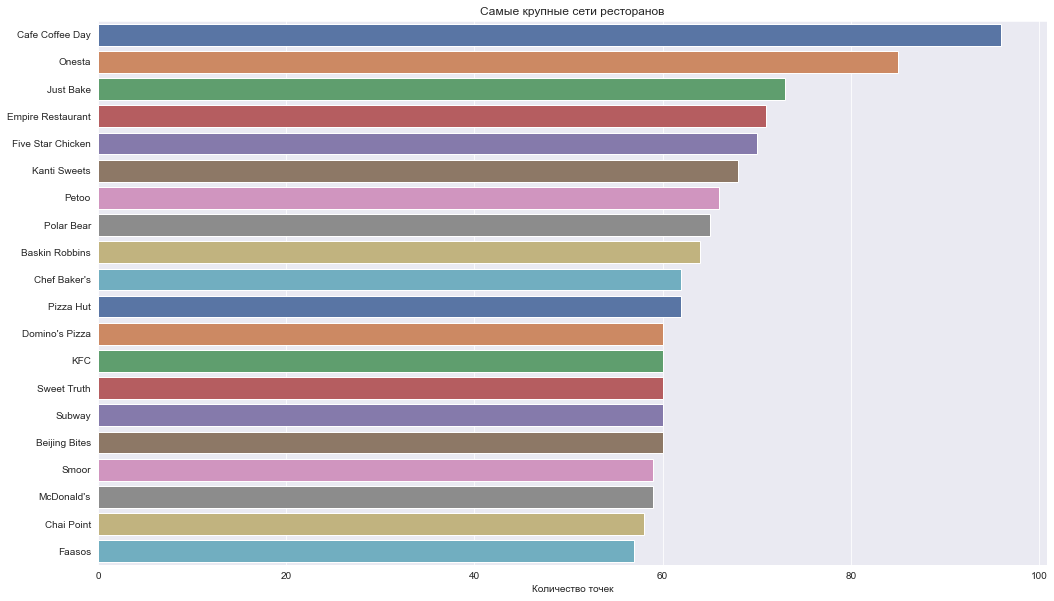

In [7]:
plt.figure(figsize=(17,10))
chains=df['name'].value_counts()[:20]
sns.barplot(x=chains, y=chains.index, palette='deep')
plt.title("Самые крупные сети ресторанов")
plt.xlabel("Количество точек")
plt.show()

In [8]:
df.rest_type.value_counts()[0:3]

Quick Bites      19132
Casual Dining    10330
Cafe              3732
Name: rest_type, dtype: int64

Наиболее популярные типы ресторанов - Quick Bites, Casual Dining  и Cafe

In [9]:
top20_by_num_reviews = df.groupby('name')['num_reviews'].sum().sort_values(ascending=False)[0:20]
print('Рестораны с наибольшим количеством отзывов')
print(top20_by_num_reviews)

Рестораны с наибольшим количеством отзывов
name
Hammered                          5955284
Truffles                          3879957
Mast Kalandar                     3354424
Onesta                            3353552
Cafe Azzure                       2985916
Smally's Resto Cafe               2856249
Oh! Calcutta                      2798904
Brooks and Bonds Brewery          2742926
Crawl Street                      2741054
Little Green Cafe                 2382740
Glen's Bakehouse                  2357013
Cafe @ Elanza                     2303300
Stoner                            2298133
Gilly's Restobar                  2286437
Indy's Comfort Food               2195374
Zee5 Loft                         2156451
Koramangala Social                2141890
Skoolroom                         2068111
Asia Kitchen By Mainland China    2050759
Soda Bottle Opener Wala           2049694
Name: num_reviews, dtype: int64


In [10]:
df.isnull().sum()

url                 0
address             0
name                0
online_order        0
book_table          0
rate             7775
votes               0
phone            1208
location           21
rest_type         227
dish_liked      28078
cuisines           45
cost              346
reviews_list        0
menu_item           0
type_meal           0
city                0
num_reviews         0
dtype: int64

In [11]:
df.drop(['url','phone', 'address', 'dish_liked', 'location', 'menu_item', 'votes'], axis=1, inplace=True)

In [12]:
df.isnull().sum()

name               0
online_order       0
book_table         0
rate            7775
rest_type        227
cuisines          45
cost             346
reviews_list       0
type_meal          0
city               0
num_reviews        0
dtype: int64

In [13]:
print('Распределение количества ресторанов по районам города')
print(df['city'].value_counts())

Распределение количества ресторанов по районам города
BTM                      3279
Koramangala 7th Block    2938
Koramangala 5th Block    2836
Koramangala 4th Block    2779
Koramangala 6th Block    2623
Jayanagar                2371
JP Nagar                 2096
Indiranagar              1860
Church Street            1827
MG Road                  1811
Brigade Road             1769
Lavelle Road             1744
HSR                      1741
Marathahalli             1659
Residency Road           1620
Whitefield               1620
Bannerghatta Road        1617
Brookefield              1518
Old Airport Road         1425
Kammanahalli             1329
Kalyan Nagar             1309
Basavanagudi             1266
Sarjapur Road            1261
Electronic City          1229
Bellandur                1227
Frazer Town              1185
Malleshwaram             1096
Rajajinagar              1079
Banashankari              863
New BEL Road              740
Name: city, dtype: int64


Удаляем рестораны с пропущенными значениями rest_type, cuisines, cost, rate

In [14]:
df.dropna(subset=['rest_type', 'cuisines', 'cost', 'rate'], inplace=True)

In [15]:
df.head()

,name,online_order,book_table,rate,rest_type,cuisines,cost,reviews_list,type_meal,city,num_reviews
0,Jalsa,1,1,4.1/5,Casual Dining,"North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",Buffet,Banashankari,3955
1,Spice Elephant,1,0,4.1/5,Casual Dining,"Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",Buffet,Banashankari,5256
2,San Churro Cafe,1,0,3.8/5,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",Buffet,Banashankari,7549
3,Addhuri Udupi Bhojana,0,0,3.7/5,Quick Bites,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",Buffet,Banashankari,14876
4,Grand Village,0,0,3.8/5,Casual Dining,"North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",Buffet,Banashankari,702


In [16]:
df['cost'] = df['cost'].apply(lambda x: x.replace(',',''))
df['cost'] = df.cost.astype(float)

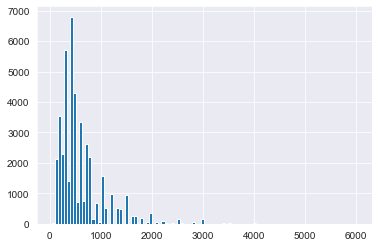

In [17]:
df['cost'].hist(bins=100);

In [18]:
df['rate'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

In [19]:
df = df[df.rate !='NEW']
df = df[df['rate'] !='-']

In [20]:
df['rate']= df['rate'].apply(lambda x: x.replace('/5', ''))

df['rate'] = df['rate'].str.strip().astype('float')

restaurants = list(df['name'].unique())
df['mean_rating'] = 0

for i in range(len(restaurants)):
    df['mean_rating'][df['name'] == restaurants[i]] = df['rate'][df['name'] == restaurants[i]].mean()

<AxesSubplot:>

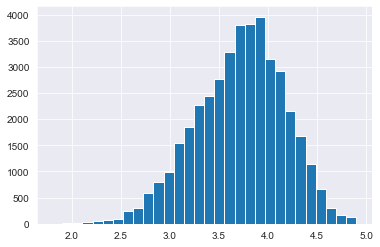

In [21]:
df['rate'].hist(bins=30)

In [22]:
df.isnull().sum()

name            0
online_order    0
book_table      0
rate            0
rest_type       0
cuisines        0
cost            0
reviews_list    0
type_meal       0
city            0
num_reviews     0
mean_rating     0
dtype: int64

In [23]:
restaurant_names = list(df['name'].unique())
print('Количество уникальных ресторанов (сети): {}'.format(len(restaurant_names)))

Количество уникальных ресторанов (сети): 6602


In [24]:
df.cuisines.values

array(['North Indian, Mughlai, Chinese', 'Chinese, North Indian, Thai',
       'Cafe, Mexican, Italian', ..., 'Continental', 'Finger Food',
       'Finger Food, North Indian, Continental'], dtype=object)

In [25]:
def wordfreq(series):
    wordfreq = {}
    for words in series:
        for word in words.split(','):
            if word.strip() not in wordfreq:
                wordfreq[word.strip()] = 0
            wordfreq[word.strip()] += 1
    return wordfreq
cuisines = wordfreq(df.cuisines.values)

In [26]:
top10_cuisines = pd.Series(cuisines).sort_values(ascending=False)[0:10]
print('ТОП-10 популярных кухнь')
print('-'*10)
print(top10_cuisines)

ТОП-10 популярных кухнь
----------
North Indian    17212
Chinese         12859
South Indian     6357
Fast Food        6324
Continental      5197
Biryani          5018
Cafe             4785
Desserts         4506
Beverages        3836
Italian          3177
dtype: int64


In [27]:
df.cuisines = df.cuisines.apply(lambda x: re.sub(',',' ',re.sub(' ','',x)).strip())
df.rest_type = df.rest_type.apply(lambda x: re.sub(',',' ',re.sub(' ','',x)).strip())
df.type_meal = df.type_meal.apply(lambda x: x.replace(' ', ''))
df.city = df.city.apply(lambda x: x.replace(' ', ''))

In [28]:
df["combined"] = df['cuisines'] + ' ' + df['type_meal'] + ' ' + df['rest_type'] + ' ' + df['city']

In [29]:
def add_features(row):
    if row['online_order'] == 1:
        row["combined"] += ' onlineOrder'
    if row['book_table'] == 1:
        row["combined"] += ' bookTable'
    return row

df = df.apply(lambda x: add_features(x), axis=1)

In [30]:
df["combined"].sample(5)

10549    Chinese NorthIndian Dine-out QuickBites BTM on...
48106    Asian Burger Chinese FingerFood Dine-out Bar C...
47230    European Continental Chinese Thai Buffet FineD...
25410    SouthIndian Delivery CasualDining Kammanahalli...
20022    NorthIndian Chinese Delivery Delivery Jayanaga...
Name: combined, dtype: object

In [31]:
df_percent = df.sample(frac=0.7)
df_percent['idx'] = df_percent.index

In [32]:
vectorizer = TfidfVectorizer(dtype='float32')
matrix = vectorizer.fit_transform(df_percent["combined"])

In [33]:
cosine_similarities = cosine_similarity(matrix, matrix)

In [34]:
def recommend(sample, cosine_similarities = cosine_similarities):

    idx = sample.idx
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)

    top30_indexes = list(score_series.iloc[0:31].index)

    recommend_restaurant = pd.DataFrame(columns=['name', 'combined', 'cuisines', 'rate', 'cost', 'city'])

    for each in top30_indexes:
        recommend_restaurant = recommend_restaurant.append(pd.DataFrame(df_percent[['name', 'combined', 'cuisines','rate', 'cost', 'city']][df_percent.index == each]))

    recommend_restaurant = recommend_restaurant.sort_values(by='rate', ascending=False).head(10)

    print('TOP %s RECOMMENDED RESTAURANTS: ' % (str(len(recommend_restaurant))))

    return recommend_restaurant

In [35]:
restaurant = df_percent.sample(1).iloc[0]
print(restaurant)
sample_idx = restaurant.idx

recommend(restaurant)

name                                       Shivaji Military Hotel
online_order                                                    0
book_table                                                      0
rate                                                          4.3
rest_type                                            CasualDining
cuisines                                      SouthIndian Biryani
cost                                                        450.0
reviews_list    [('Rated 5.0', "RATED\n  Wanted to visit this ...
type_meal                                                Dine-out
city                                                      JPNagar
num_reviews                                                148965
mean_rating                                                  3.75
combined        SouthIndian Biryani Dine-out CasualDining JPNagar
idx                                                         23588
Name: 23588, dtype: object
TOP 10 RECOMMENDED RESTAURANTS: 


,name,combined,cuisines,rate,cost,city
23588,Shivaji Military Hotel,SouthIndian Biryani Dine-out CasualDining JPNagar,SouthIndian Biryani,4.3,450.0,JPNagar
6271,White Plate,Thai Continental NorthIndian Dine-out CasualDi...,Thai Continental NorthIndian,4.2,1500.0,BrigadeRoad
8437,A2B - Adyar Ananda Bhavan,SouthIndian NorthIndian StreetFood Delivery Ta...,SouthIndian NorthIndian StreetFood,4.2,200.0,BTM
11426,Tapri By The Corner,FastFood Dine-out QuickBites BTM onlineOrder,FastFood,4.1,250.0,BTM
19412,Dr. Sheesha,Cafe Chinese Continental Italian Cafes Cafe Ja...,Cafe Chinese Continental Italian,4.1,800.0,Jayanagar
14277,The Daily,Rajasthani NorthIndian Dine-out QuickBites Ele...,Rajasthani NorthIndian,4.0,400.0,ElectronicCity
12215,The Oriental Spice - Ashraya Hotel,Chinese Thai Indonesian Delivery CasualDining ...,Chinese Thai Indonesian,3.9,1300.0,ChurchStreet
25988,Raidan Restaurant,Arabian Chinese NorthIndian Dine-out CasualDin...,Arabian Chinese NorthIndian,3.9,450.0,Kammanahalli
20577,Flavour of China,Chinese Delivery CasualDining Jayanagar online...,Chinese,3.8,550.0,Jayanagar
12119,Kadamba Foodline,Chinese NorthIndian SouthIndian StreetFood Del...,Chinese NorthIndian SouthIndian StreetFood,3.7,400.0,ChurchStreet


In [36]:
from sklearn.cluster import KMeans
#
#
# # Выбор количества кластеров

# distortions = []
# n = 15
# for i in range(3, n):
#     print(i)
#     km = KMeans(n_clusters=i,
#                 init='k-means++',
#                 n_init=10,
#                 max_iter=300,
#                 random_state=0)
#     km.fit(cosine_similarities)
#     distortions.append(km.inertia_)
#
# plt.figure(figsize=(15, 9))
# plt.plot(range(3, n), distortions, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
# plt.tight_layout()
# plt.show();

In [ ]:
km = KMeans(n_clusters=10,
            init='random',
            n_init=11,
            max_iter=300,
            tol=1e-04,
            random_state=0)

km.fit(cosine_similarities)

In [ ]:
clusters = km.predict(cosine_similarities)
x_dist = km.transform(cosine_similarities)
df_percent['cluster'] = clusters

## Выводы
Проведено исследование данных.
Разработана content-based рекомендательная система на основе данных об отзывах на рестораны от TripAdvisor.
Для рекомендательной системы были выделены следующие признаки, как наиболее важные:
- тип кухни (cuisines)
- тип ресторана (rest_type)
- тип еды (type_meal)
- расположение ресторана (район города) (listed_in(city))
- возможность онлайн заказа (online_order)
- возможность бронирования столика (book_table)

Выбранные признаки были преобразованы в частотные векторы c помощью TFIDFVectorizer. Близость векторов оценивалась с помощью косинусного расстояния.
В итоге в рекомендации попадают наиболее близкие рестораны дополнительно отсортированные по рейтингу.

К сожалению, качество рекомендаций измерить не хватило времени :( (Планировал провести кластеризацию всех ресторанов с помощью KMeans, по расстояниям до центров
кластеров оценивать качество)
Но и без измерения видно, что рекомендации очень близки.
В развитие системы: можно учитывать еще признак цены, понравившиеся блюда, а также поработать с отзывами - вытащить оттуда полезную информацию.